# Introduction

In this notebook I will be investigating Variational Auto-Encoders (VAEs). I will begin by working through the mathematical setup behind such models, and then I will implement one in TensorFlow.

I will be using a combination of class notes, the *Auto-Encoding Variational Bayes* [paper](https://arxiv.org/abs/1312.6114), this [TF tutorial](https://www.tensorflow.org/tutorials/generative/cvae), this [Keras tutorial](https://keras.io/examples/generative/vae/), and a smattering of other internet resouces.

Before we dive in, I will give a brief high-level overview of VAEs. As the name suggests the model encodes input data as some lower dimensional representation, which is called the latent state. The key difference between a regular encoder is that the latent state determines a probability distribution. A decoder can then sample from this distribution to generate an image.

# Mathematical Setup

First, we assume that we have some dataset $D=\{x_i\}_{i=1}^N$ made up of i.i.d samples from the random variable $X$.

Next, we assume that there exists a latent random variable $Z$ which is somehow involved in producing $X$.

Ignoring our intended setting of a neural network for a moment, we outline the assumed process for generating a data point $x_i$. The associated latent variable $z_i$ is produced according to the prior distribution $p_{\theta^*}(z)$, and then $x_i$ is produced according to the conditional distribution $p_{\theta^*}(x|z)$. In this case $\theta^*$ are the exact unknown parameters that govern these random processes.

Overall we would like to determine two things: $p_\theta(x)$ and $p_\theta(z|x)$, where $\theta$ are some parameters. The first distribution is the marginal likelihood of $X$ and the second is the posterior distribution of $Z$. In a general sense there exists methods for determining these, but in our case it is intractable.

Moving back to neural networks, we will approximate the posterior as $q_\phi(z|x)$, where the parameters $\phi$ make up our encoder. Similarily, the we will define the decoder as $p_\theta(x|z)$ which has parameters $\theta$.

Now we write the following:
$$
\begin{align}
    \log p_\theta(x_1,...,x_N)&=\sum_{i=1}^N \log p_\theta(x_i)\\
    \log p_\theta(x_i)&= E_{q_\theta(z|x_i)}[-\log q_\theta(z|x_i)+\log p_\theta(x_i,z)]\\
    &\geq -KL(q_\phi(z|x_i)||p_\theta(z))+E_{q_\phi(z|x_i)}[\log p_\theta(x_i|z)]
\end{align}
$$

We will not go through the entire derivation here, but we will work on unpacking what we have. The first line is simply writing out the log-likelihood while the second and third lines are equivalent lower bounds. We note that the KL operator is the Kullback-Leibler divergence -- a measure of distance between two distributions. By maximizing this lower bound we can thus maximize the log-likelihood, and this will be our approach for training the network.

In practice either of the equivalent lower bounds can be used as a loss, but both require two more steps. First, the expectation is approximated as a Monte Carlo estimate, and we apply what is known as the "reparameterization trick". The Monte Carlo estimate means we just sample a finite number of $z$, and the reparameterization is carried out as follows:

$$
z=g_\phi(\epsilon, x_i)\quad\epsilon\sim p(\epsilon)
$$

Where $p(\epsilon)$ is some distribution determined by the data one is working with, and $g_\phi$ is a differentiable function. This trick is neccessary for backpropagation.

Okay, so what have we achieved with this? We have a general structure to our model, and importantly we have a loss function for training it. I think everything will make a little more sense once we apply it to some real situation, so lets do just that.

# Building a Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp

We will be using the MNIST handwritten digits dataset, which we set up and briefly examine below. I will note that following the math above, this dataset is our $D$ and each image is an $x_i$ which has been produced from some unknown distribution.

In [2]:
#Download
(train, _), (test, _) = keras.datasets.mnist.load_data()

print(f'Train set size: {train.shape[0]}')
print(f'Test set size: {test.shape[0]}')

Train set size: 60000
Test set size: 10000


We can see that we have 60,000 testing images and 10,000 training images. The images are stored as vectors, so we need to reshape them and we will also rescale them to the interval \[0,1\]. We can also concatenate the two splits into one, as we will not be needing a test set. 

Lastly, we note that we could binarize our data and look at a discrete VAE. This makes sense as the images we are considering are almost binary to begin with as pixels are mostly white or black.

In [3]:
#Reshape and rescale
train = train.reshape((train.shape[0], 28, 28, 1))/255
test = test.reshape((test.shape[0], 28, 28, 1))/255

#Concatenate
train = np.concatenate((train, test), axis=0)

# #Pre-binarization
# fig, ax = plt.subplots(1,2,figsize=(8,8))

# ax[0].imshow(train[0], cmap='gray')
# ax[0].tick_params(axis='both', labelbottom=False, 
#                        labelleft=False, bottom=False, left=False)

# #Binarize
# train = np.where(train>0.5, 1.0, 0.0).astype('float32')

# ax[1].imshow(train[0], cmap='gray')
# ax[1].tick_params(axis='both', labelbottom=False, 
#                        labelleft=False, bottom=False, left=False)

The binarized image is much sharper, but still retains the overall shape and meaning. We can see some more example images below.

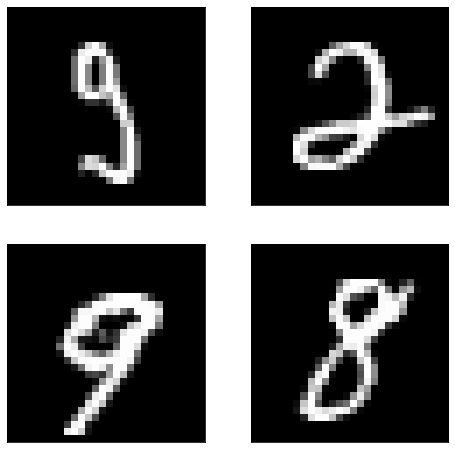

In [4]:
#Look at a picture
fig, ax = plt.subplots(2,2,figsize=(8,8))

for i in range(2):
    for j in range(2):
        ax[i,j].imshow(train[np.random.randint(1,100)], cmap='gray')

        ax[i,j].tick_params(axis='both', labelbottom=False, 
                       labelleft=False, bottom=False, left=False)

Lastly, we will set convert our dataset to a TF dataset object which will be easier to work with.

In [5]:
from tensorflow.data.experimental import AUTOTUNE

train_size = train.shape[0]
batch_size = 256

train = (tf.data.Dataset.from_tensor_slices(train)
             .shuffle(train_size).batch(batch_size).prefetch(AUTOTUNE))

It looks like we are good to go in terms of data, so now we need to define our network. We will do this is two parts, one for the encoder and one for the decoder.

We start by writing a custom layer that will perform the reparameterization trick for us. With this we have taken $\epsilon\sim\mathcal{N}(0,I)$ and $g_\theta(\epsilon, x)=\mu(x)+\sigma(x)\epsilon$, where $\mu$ and $\sigma$ are the mean and standard deviation respectively. Although we are in fact using a slightly altered log-variance for numerical reasons.

In [6]:
#Reparamaterization trick
class Sampler(keras.layers.Layer):

    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

Now we define the encoder architecture which is a small CNN, and the decoder architecture which is a small transpose CNN. We set our latent dimension to be 2 for reasons we will see later, and we define the base number of filters for our CNN as 32.

In [57]:
#General network hyperparams
encoded_size = 2 #20 if following instructions later
base = 32

In [58]:
encoder = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    keras.layers.Conv2D(filters=base, kernel_size=3, strides=1, 
                        padding='same', activation='swish'),
    
    keras.layers.Conv2D(filters=base, kernel_size=3, strides=2, 
                        padding='same', activation='swish'),
    
    keras.layers.Conv2D(filters=2*base, kernel_size=3, strides=1, 
                        padding='same', activation='swish'),
    
    keras.layers.Conv2D(filters=2*base, kernel_size=3, strides=1, 
                        padding='valid', activation='swish'),
    keras.layers.Flatten(),
    keras.layers.Dense(units=2*encoded_size)
])

encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 36868     
Total params: 101,860
Trainable params: 101,860
Non-trainable params: 0
________________________________________________

In [59]:
decoder = keras.Sequential([
    keras.layers.InputLayer(input_shape=(encoded_size,)),
    keras.layers.Dense(units=7*7*2*base, activation='swish'),
    keras.layers.Reshape([7,7,2*base]),
    keras.layers.Conv2DTranspose(filters=2*base, kernel_size=3, 
                                 strides=1, padding='same', 
                                 activation='swish'),
    
    keras.layers.Conv2DTranspose(filters=2*base, kernel_size=3, 
                                 strides=2, padding='same', 
                                 activation='swish'),
    
    keras.layers.Conv2DTranspose(filters=base, kernel_size=3, strides=1, 
                                 padding='same', activation='swish'),
    
    keras.layers.Conv2DTranspose(filters=base, kernel_size=3, 
                                 strides=2, padding='same', 
                                 activation='swish'),
    
    keras.layers.Conv2DTranspose(filters=1, kernel_size=3, 
                                 strides=1, padding='same', 
                                 activation='sigmoid')
])

decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 14, 14, 32)        18464     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 28, 28, 1)        

Here we have defined a custom model class that will help us train the encoder and decoder as one cohesive unit. I will note that this was mostly obtained from the Keras tutorial cited above.

In [60]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.sampler = Sampler()
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = tf.split(self.encoder(data), num_or_size_splits=2, axis=1)
            z = self.sampler((z_mean, z_log_var))
            
            
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

We are using the lower bound that includes the distinct KL divergence term as our loss. The other term is referred to as the "reconstruction loss". Now we are ready to train, which we will do so for 20 epochs.

In [44]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
vae.fit(train, epochs=30)

Epoch 1/30
274/274 [==============================] - 21s 73ms/step - loss: 425.6787 - reconstruction_loss: 310.6408 - kl_loss: 8.1847
Epoch 2/30
274/274 [==============================] - 18s 66ms/step - loss: 192.9609 - reconstruction_loss: 166.0189 - kl_loss: 14.2400: 11s - loss: 203.3984 - reconstruction_loss: 185.6631 -  - ETA: 7s - loss: 199.2422 - reconstruction_loss: 177.3616 - kl_loss: 12. - ETA: 7s - loss: 199.1216 - reconstruction_loss: 177.1519 -  - ETA - ETA: 2s - loss: 194.5935 - reconstruction_loss: 168.8966 - kl_loss: 13.78 - ETA: 2s - l
Epoch 3/30
274/274 [==============================] - 19s 68ms/step - loss: 154.7214 - reconstruction_loss: 128.9830 - kl_loss: 20.2245
Epoch 4/30
274/274 [==============================] - 19s 69ms/step - loss: 136.9476 - reconstruction_loss: 110.9627 - kl_loss: 23.2381
Epoch 5/30
274/274 [==============================] - 19s 70ms/step - loss: 127.7006 - reconstruction_loss: 101.3292 - kl_loss: 24.7661
Epoch 6/30
274/274 [============

It looks like we probably could have kept training, but lets see where this got us. First, we generate a latent variable according to the same prior distribution, and then we pass it through our decoder.

In [36]:
gen_z = tf.random.normal(shape=(1,encoded_size))
gen_x = vae.decoder.predict(gen_z)
gen_x = gen_x.reshape((28,28,1))

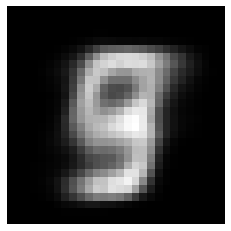

In [37]:
plt.imshow(gen_x, cmap='gray')
plt.axis('off');

That is clearly an image of a nine, and if we sharpen it up some we can more clearly see this.

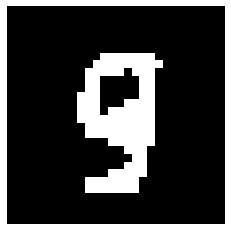

In [38]:
plt.imshow(np.where(gen_x.reshape((28,28,1)) > 0.4, 1, 0), cmap='gray')
plt.axis('off');

Well, that looks okay. Lets look at a structured plot of images produced from variations in the latent space. Note that this code was obtained from the tensorflow tutorial, and that we can do this because we have a two dimensional latent space.

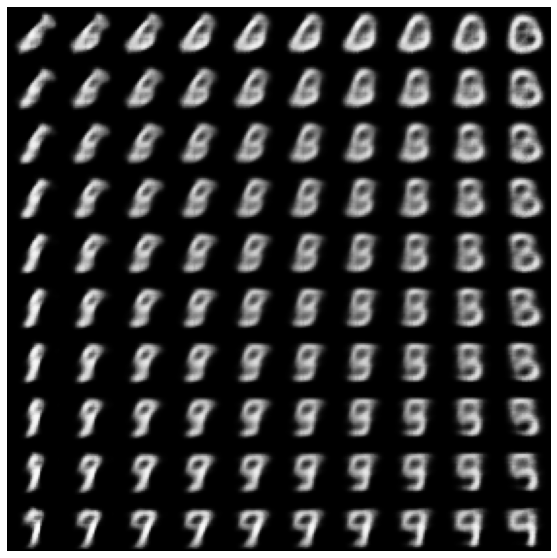

In [39]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            
            x_decoded = model.decoder.predict(z)
            
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()
    
plot_latent_images(vae, 10)

Interesting, some of those images look quite a bit better. We can identify nines, eights, zeros, and fives. I believe some of the output is better in this case because we are taking distinct quantiles from our generated normal distribution which cuases less interaction and results in more delineated images.

One notable problem with reducing the dimension of the latent space is that it will not have as much of a modeling capacity, so the variation in our images will likely be smaller. To see if this is the case I have changed the latent dimensions and then re-trained the network using the code above. To make everything consistent I then changed everything back, so if you want to produce the output below then re-build the model with the embedding dimension changed.

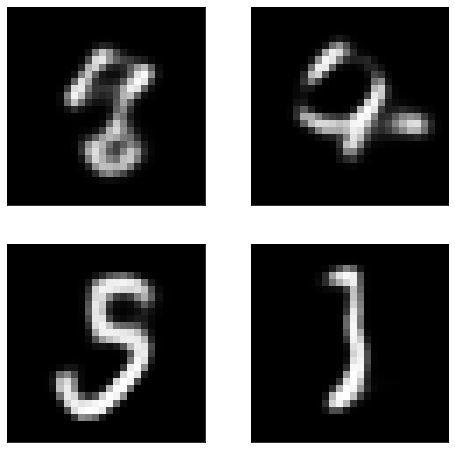

In [56]:
#Look at a picture
fig, ax = plt.subplots(2,2,figsize=(8,8))

for i in range(2):
    for j in range(2):
        gen_z = tf.random.normal(shape=(1,encoded_size))
        gen_x = vae.decoder.predict(gen_z)
        gen_x = gen_x.reshape((28,28,1))
        
        ax[i,j].imshow(gen_x, cmap='gray')

        ax[i,j].tick_params(axis='both', labelbottom=False, 
                       labelleft=False, bottom=False, left=False)

There certainly is far greater variation in the produced images, but I think it could use to be trained for longer.